# PCA Demo

This uses random data to illustrate the concept of **maximum variance**.

Additional references:

- [PCA](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)
- [Relationship between PCA and SVD](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca)

## Setup

Imports:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spla
from sklearn.decomposition import PCA

RNG seed:

In [2]:
rng = np.random.default_rng(20201114)

## Compute a PCA

Let's compute a bunch of multivariate normals in 3 dimensions with some correlation:

In [3]:
means = [5, 10, -2]
mcv = [
    [1, 0.7, 0.2],
    [0.7, 1, -0.3],
    [0.2, -0.3, 1]
]
n = 500
data = rng.multivariate_normal(means, mcv, size=n)
data

array([[ 5.31358291, 10.10454979, -1.28170015],
       [ 4.63890901,  9.22500074, -0.22529381],
       [ 5.85599736, 10.77474896, -1.95883841],
       ...,
       [ 4.4931347 ,  9.93950184, -0.95846614],
       [ 4.91058303,  9.73080603, -2.05767846],
       [ 7.23444003, 12.52878242, -2.53911509]])

We how have 500 rows and 3 columns.

Let's confirm the data has its expected means:

In [4]:
obs_means = np.mean(data, axis=0)
obs_means

array([ 4.99862798,  9.95351358, -1.9301308 ])

That is close to our configured means.  Let's see the covariance matrix:

In [5]:
np.cov(data.T)

array([[ 1.04670135,  0.74075551,  0.22196162],
       [ 0.74075551,  1.06484044, -0.31102634],
       [ 0.22196162, -0.31102634,  1.04063369]])

That also matches what we configured!

Let's do scatterplots:

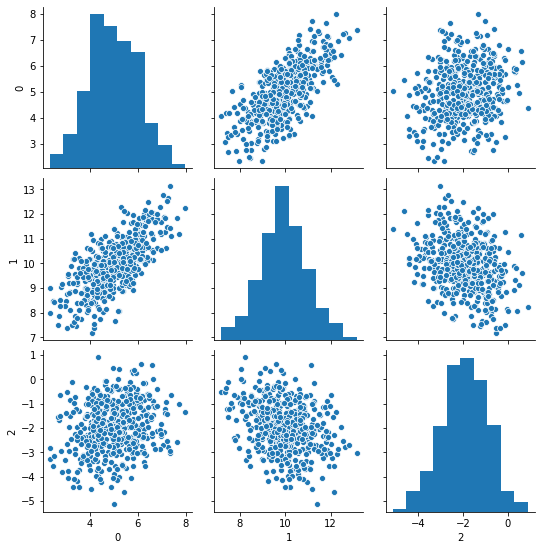

In [6]:
sns.pairplot(pd.DataFrame(data))

We can see strong correlation between 0 and 1, and negative but much milder correlation between 1 and 2.

## PCA

Now we're going to compute the *mean-centered* data in prepration for the PCA - thank you NumPy broadcasting:

In [7]:
mc_data = data - obs_means
mc_data

array([[ 0.31495493,  0.15103621,  0.64843064],
       [-0.35971896, -0.72851284,  1.70483699],
       [ 0.85736938,  0.82123538, -0.02870762],
       ...,
       [-0.50549327, -0.01401174,  0.97166465],
       [-0.08804494, -0.22270755, -0.12754766],
       [ 2.23581205,  2.57526884, -0.60898429]])

And now we'll compute a 2D PCA:

In [8]:
P, sig, Qt = spla.svds(mc_data, 2)
P.shape

(500, 2)

In [9]:
Qt.shape

(2, 3)

In [10]:
sig

array([24.41604313, 29.99470823])

In [11]:
Qt

array([[ 0.34825608, -0.20454769,  0.91481033],
       [-0.68168465, -0.72513793,  0.0973705 ]])

Now, we're going to compute the **explained variance** from the **singular values**, following [this discussion](https://stats.stackexchange.com/a/134283/389), as follows:

$$\lambda_i = s_i^2 / (n - 1)$$

In [12]:
ev = np.square(sig) / (n - 1)
ev

array([1.19467568, 1.80297099])

The *last* row of the $Q^T$ matrix explains the **most** variance, because `svds` returns the rows in order of *increasing* singular value instead of *decreasing*.

Let's actually look at the line:

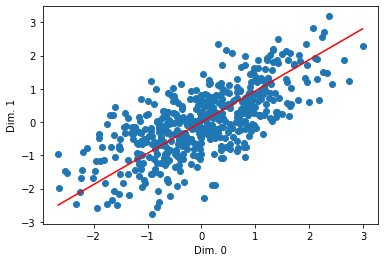

In [13]:
plt.scatter(mc_data[:, 0], mc_data[:, 1])
pca_xs = np.linspace(np.min(mc_data[:, 0]), np.max(mc_data[:, 0]))
pca_ys = pca_xs * Qt[1,0] / Qt[1,1]
plt.plot(pca_xs, pca_ys, color='red')
#plt.scatter(Qt[:, 0], Qt[:, 1], color='red')
# plt.arrow(0, 0, Qt[1, 0] * 3, Qt[1, 1] * 3, color='red', width=0.05, head_width=0.3)
# plt.arrow(0, 0, Qt[0, 0] * 3, Qt[1, 1] * 3, color='green', width=0.05, head_width=0.3)

plt.ylabel('Dim. 1')
plt.xlabel('Dim. 0')
plt.show()

What if we want to see multiple ones?

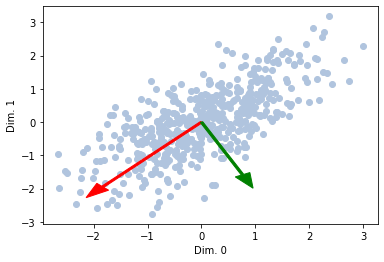

In [14]:
lens = np.sqrt(ev) * 2
plt.scatter(mc_data[:, 0], mc_data[:, 1], color='lightsteelblue')
plt.arrow(0, 0, Qt[1, 0] * lens[1], Qt[1, 1] * lens[1], color='red', width=0.05, head_width=0.3)
plt.arrow(0, 0, Qt[0, 0] * lens[0], Qt[1, 1] * lens[0], color='green', width=0.05, head_width=0.3)

plt.ylabel('Dim. 1')
plt.xlabel('Dim. 0')
plt.show()

## Comparing with SKlearn PCA

Let's compare this with SKLearn's PCA.

In [15]:
pca = PCA(2)
pca.fit(data)

PCA(n_components=2)

It learns the means:

In [16]:
pca.mean_

array([ 4.99862798,  9.95351358, -1.9301308 ])

It learns our matrices, although the rows will be in the opposite order:

In [17]:
pca.components_

array([[ 0.68168465,  0.72513793, -0.0973705 ],
       [-0.34825608,  0.20454769, -0.91481033]])

And it learns the explained variances:

In [18]:
pca.explained_variance_

array([1.80297099, 1.19467568])

These match what we got from `svds`, with some possible sign flips and the reverse-ordered data points.